模拟数据集中的动作,就是传统的深度学习而已

In [1]:
import torch


#封装数据集
class Dataset(torch.utils.data.Dataset):

    def __init__(self):
        import numpy as np
        data = np.loadtxt('离散动作.txt')
        self.state = torch.FloatTensor(data[:, :4])
        self.action = torch.LongTensor(data[:, -1])

    def __len__(self):
        return len(self.state)

    def __getitem__(self, i):
        return self.state[i], self.action[i]


dataset = Dataset()

len(dataset), dataset[0]

(20000, (tensor([-0.0028,  0.0180, -0.0188, -0.0368]), tensor(0)))

In [2]:
#数据加载器
loader = torch.utils.data.DataLoader(dataset=dataset,
                                     batch_size=8,
                                     shuffle=True,
                                     drop_last=True)

len(loader), next(iter(loader))

(2500,
 [tensor([[ 1.5843e-01, -5.3389e-02,  2.4347e-04,  1.3181e-01],
          [ 1.5329e-01,  1.9470e-01,  4.8345e-03, -2.3730e-01],
          [ 1.6449e-01,  1.5640e-01,  8.6902e-04, -1.7631e-01],
          [ 5.2323e-02,  1.6990e-01,  1.5965e-03, -1.8915e-01],
          [ 7.1826e-02, -3.7482e-02, -1.0227e-02,  1.6802e-01],
          [ 9.2822e-02,  1.5960e-01,  9.0184e-03, -1.6790e-01],
          [ 1.3534e-01, -2.3736e-01,  2.2018e-02,  3.8089e-01],
          [ 3.7986e-02, -1.7835e-02, -2.2120e-03,  1.0894e-01]]),
  tensor([1, 0, 0, 0, 1, 0, 1, 1])])

In [3]:
#定义模型
model = torch.nn.Sequential(
    torch.nn.Linear(4, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 64),
    torch.nn.ReLU(),
    torch.nn.Linear(64, 2),
)

model(torch.randn(2, 4)).shape

torch.Size([2, 2])

In [4]:
#训练
def train():
    model.train()
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)
    loss_fn = torch.nn.CrossEntropyLoss()

    for epoch in range(10):
        for i, (state, action) in enumerate(loader):
            out = model(state)

            loss = loss_fn(out, action)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()

        if epoch % 1 == 0:
            out = out.argmax(dim=1)
            acc = (out == action).sum().item() / len(action)
            print(epoch, loss.item(), acc)


train()

0 0.23804855346679688 0.875
1 0.23378416895866394 1.0
2 0.6556164622306824 0.75
3 0.14761586487293243 1.0
4 0.2092546820640564 1.0
5 0.12375369668006897 1.0
6 0.16725218296051025 0.875
7 0.3405707776546478 0.875
8 0.0441044345498085 1.0
9 0.7327598333358765 0.875


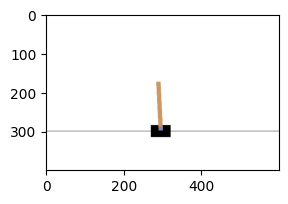

In [5]:
import gym


#定义环境
class MyWrapper(gym.Wrapper):

    def __init__(self):
        env = gym.make('CartPole-v1', render_mode='rgb_array')
        super().__init__(env)
        self.env = env
        self.step_n = 0

    def reset(self):
        state, _ = self.env.reset()
        self.step_n = 0
        return state

    def step(self, action):
        state, reward, terminated, truncated, info = self.env.step(action)
        over = terminated or truncated

        #限制最大步数
        self.step_n += 1
        if self.step_n >= 200:
            over = True
        
        #没坚持到最后,扣分
        if over and self.step_n < 200:
            reward = -1000

        return state, reward, over

    #打印游戏图像
    def show(self):
        from matplotlib import pyplot as plt
        plt.figure(figsize=(3, 3))
        plt.imshow(self.env.render())
        plt.show()


env = MyWrapper()

env.reset()

env.show()

In [6]:
from IPython import display
import random


#玩一局游戏并记录数据
def play(show=False):
    reward_sum = 0

    state = env.reset()
    over = False
    while not over:
        action = model(torch.FloatTensor(state).reshape(1, 4)).argmax().item()
        if random.random() < 0.1:
            action = env.action_space.sample()

        state, reward, over = env.step(action)
        reward_sum += reward

        if show:
            display.clear_output(wait=True)
            env.show()

    return reward_sum


#测试
sum([play() for _ in range(20)]) / 20

200.0

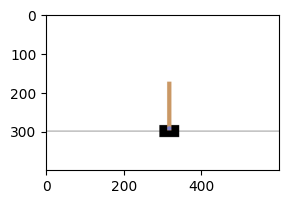

200.0

In [7]:
play(True)